In [58]:
import numpy as np
import pandas as pd
import os

from lib.plotting import *
from lib.preferences import *

In [59]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches
import seaborn as sns

import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style("ticks")
sns.set_style('white')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

## Load summary tables

In [60]:
br_df = pd.read_csv("../summary_tables/2020-04-28_br-corr.csv")
gamma_df = pd.read_csv("../summary_tables/2020-04-29_gamma-corr.csv")
nv_df = pd.read_csv("../summary_tables/2020-04-29_nv-corr.csv")

In [61]:
# Restrict to equilibrium epoch
br_df = br_df.query("epoch == 'InitVar'")
gamma_df = gamma_df.query("epoch == 'InitVar'")
nv_df = nv_df.query("epoch == 'InitVar'")

# Remove E[X_h] <= 0.2; as there is considerable extinction here
br_df = br_df.query("HX_expected > 0.21")
gamma_df = gamma_df.query("HX_expected > 0.21")
nv_df = nv_df.query("HX_expected > 0.21")

## Summarize regression results

In [62]:
def create_ols_summary(x_h, genetic_metrics, df):
    """
    Create a table summarize OLS results for every
    statistic in `genetic_metrics` against `x_h`
    
    """

    stats = ["metric", "mu", "r2", "slope", "conf_down", "conf_up"]
    dt_ols = {}
    for stat in stats:
        dt_ols[stat] = []

    for metric in genetic_metrics:
        # Fit Model
        ols = smf.ols(metric + "~" + x_h, df).fit()

        # Statistics
        r2 = ols.rsquared
        slope = ols.params[x_h]
        conf_down, conf_up = ols.conf_int().loc[x_h]
        mu = df[metric].mean()

        # Storage
        dt_ols["metric"].append(metric)
        dt_ols["mu"].append(mu)
        dt_ols["r2"].append(r2)
        dt_ols["slope"].append(slope)
        dt_ols["conf_down"].append(conf_down)
        dt_ols["conf_up"].append(conf_up)

    return pd.DataFrame(dt_ols)[stats]

In [63]:
genetic_metrics += ibd_metrics

In [64]:
br_ols = create_ols_summary(x_h="HX_expected", 
                            genetic_metrics=genetic_metrics,
                            df=br_df)

/anaconda2/envs/dream/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [65]:
gamma_ols = create_ols_summary(x_h="HX_expected", 
                               genetic_metrics=genetic_metrics,
                               df=gamma_df)

In [66]:
nv_ols = create_ols_summary(x_h="HX_expected", 
                            genetic_metrics=genetic_metrics,
                            df=nv_df)

## Munge to assist plotting
- Limit to tight_metrics
- Sort by tight_metrics
- Add an "index" column
- Add a "intervention" column
- Add a "color" column
- Merge for all data sets
- Compute a "mean normalized slope"

In [67]:
def get_metric_ix(metric, tight_metrics):
    return [j for j, m in enumerate(tight_metrics[::-1]) if m == metric][0]

In [68]:
def munge_df(df, intervention, col, tight_metrics):
    df = df.copy()
    df.query("metric in @tight_metrics", inplace=True)
    df.insert(0, "ix", [get_metric_ix(metric, tight_metrics) for metric in df["metric"]])
    df.sort_values("ix", inplace=True)
    df["intervention"] = intervention
    df["color"] = [col]*len(df)
    return df

In [69]:
g = munge_df(gamma_ols, 
             intervention="gamma", 
             col=sns.color_palette("Blues", 6)[4], 
             tight_metrics=tight_metrics)

In [70]:
b = munge_df(br_ols, 
             intervention="br", 
             col=sns.color_palette("Greens", 6)[4], 
             tight_metrics=tight_metrics)

In [71]:
n = munge_df(nv_ols, 
             intervention="nv", 
             col=sns.color_palette("Reds", 6)[4], 
             tight_metrics=tight_metrics)

In [72]:
final_df = pd.concat([g, b, n])

## Plot $r^2$ across interventions

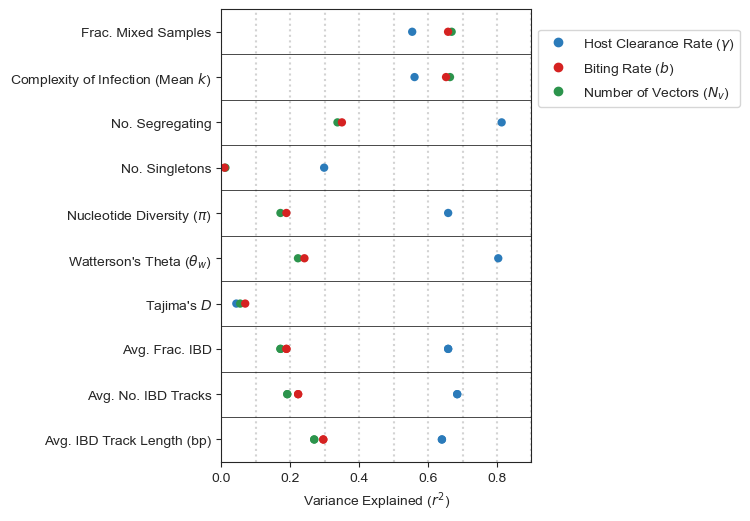

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax.scatter(final_df["r2"], 
           final_df["ix"],
           color=final_df["color"],
           marker="o",
           linewidth=0)

# Limits
ax.set_ylim((-0.5, len(tight_metrics) - 0.5))
ax.set_xlim((0, 0.9))

# Ticks
ax.set_yticks(np.arange(0, len(tight_metrics)))
ax.set_yticklabels([genetic_names[m] for m in tight_metrics[::-1]])

# Lines
for i in np.arange(len(tight_metrics)):
    ax.axhline(i - 0.5, color='black', linewidth=0.5)
for x in np.arange(0, 1.0, 0.1):
    ax.axvline(x, color='darkgrey', ls='dotted', alpha=0.5, zorder=0)
    
# Labels
ax.set_xlabel("Variance Explained ($r^2$)")

# Legend
leg_handles = [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Blues", 6)[4],
                                label="Host Clearance Rate ($\gamma$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Reds", 6)[4],
                                label="Biting Rate ($b$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Greens", 6)[4],
                                label="Number of Vectors ($N_v$)", lw=0) ]
ax.legend(handles=leg_handles, bbox_to_anchor=(1.0, 0.97))

#plt.savefig(os.path.join(output_dir, "r2_summary.pdf"), bbox_inches="tight", pad_inches=0.5)